In [1]:
import overpy
import fiona 
from fiona.crs import from_epsg
import mapnik

# Declare bounds and type of data you want to download from overpass api and save to shp file

In [2]:
api = overpy.Overpass()
# fetch all ways and nodes

south_bound = '50.82918'
west_bound  = '6.02336'
north_bound = '50.83191'
east_bound  = '6.02609'

bound_str = 'e="'+east_bound+'" '+'n="'+north_bound+'" '+'w="'+west_bound+'" '+'s="'+south_bound+'"'

# call overpass api with specified bounds
# load just ways (multiple nodes belonging to objects...will ignore single nodes) of type building

#result = api.query("""
#way(""" + south_bound+ ',' + west_bound + ',' +north_bound+ ',' +east_bound+""") ["building"];
#(._;>;);
#out body;
#""")

query = """
<osm-script>
  <union>
    <query type="way">
      <has-kv k="building"/>
      <bbox-query """+bound_str+"""/>
    </query>
  </union>
  <union>
    <item/>
    <recurse type="down"/>
  </union>
  <print limit="" mode="body" order="id"/>
</osm-script>
"""
result = api.query(query)

#print(query)
#print(new_result.ways)

#print(new_result.ways==result.ways)

#result = new_result

# store data as shape file
schema = {'geometry': 'LineString', 'properties': {'Name':'str:80'}}
shapeout = "test.shp"


[<overpy.Way id=437515420 nodes=[4353287465, 4353287468, 4353287453, 4353287456, 4353287450, 4353287447, 4353287465]>, <overpy.Way id=627320713 nodes=[5921975963, 5921975964, 5921975965, 5921975966, 5921975963]>, <overpy.Way id=627320714 nodes=[5921975967, 5921975968, 5921975969, 5921975970, 5921975967]>, <overpy.Way id=627320715 nodes=[5921975971, 5921975972, 5921975973, 5921975974, 5921975971]>, <overpy.Way id=627320717 nodes=[5921975979, 5921975980, 5921975981, 5921975982, 5921975979]>, <overpy.Way id=627320718 nodes=[5921975983, 5921975984, 5921976185, 5921976186, 5921975983]>, <overpy.Way id=627320719 nodes=[5921976187, 5921976188, 5921976189, 5921976190, 5921976187]>, <overpy.Way id=627320720 nodes=[5921976191, 5921976192, 5921976193, 5921976194, 5921976191]>, <overpy.Way id=627320721 nodes=[5921976195, 5921976196, 5921976197, 5921976198, 5921976195]>, <overpy.Way id=627320722 nodes=[5921976199, 5921976200, 5921976201, 5921976202, 5921976199]>, <overpy.Way id=627320723 nodes=[592

## Interpret data from shape file and store them in a dictionary mapnik can work with

In [3]:
with fiona.open(shapeout, 'w',crs=from_epsg(3857),driver='ESRI Shapefile', schema=schema) as output:
    for i, way in enumerate(result.ways):                
        #if (node.lat<north_bound and node.lat>south_bound and node.lon<west_bound and node.lon>east_bound ):
        # the shapefile geometry use (lon,lat) 
        line = {'type': 'LineString', 'coordinates':[(node.lon, node.lat) for node in way.nodes ]}
        prop = {'Name': way.tags.get("name", "n/a")}
        output.write({'geometry': line, 'properties':prop})

## Tell mapnik the size of the output image and name of the shapefile with the osm data

In [4]:
m = mapnik.Map(2000,2000)
ds = mapnik.Shapefile(file='test.shp')
ds.envelope()
layer = mapnik.Layer('pz_koeln') 

## Check size of the resulting bounding box...overpass bounds are just a rough indication ;) 

In [5]:
envelope = ds.envelope()
with open("map.yaml", "w") as yamlFile:
  west  = envelope[0]
  south = envelope[1]
  east  = envelope[2]
  north = envelope[3]
  yamlFile.write("map:" + "\n")
  yamlFile.write("  min_lat: " + str(south) + "\n")
  yamlFile.write("  min_lon: " + str(west)  + "\n")
  yamlFile.write("  max_lat: " + str(north) + "\n")
  yamlFile.write("  max_lon: " + str(east)  + "\n")
  print("map:")
  print("  min_lat: " + str(south))
  print("  min_lon: " + str(west))
  print("  max_lat: " + str(north))
  print("  max_lon: " + str(east))


map:
  min_lat: 50.8295206
  min_lon: 6.0237424
  max_lat: 50.8316988
  max_lon: 6.0256929


## Define projection and colors of the resulting image

In [6]:
#m.srs = "+init=epsg:3857" # web mercator: epsg:3857 , mercator(wsg84): epsg:4326
m.srs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

m.background = mapnik.Color(255,255,255,0) # set background colour to 'steelblue'. 

s = mapnik.Style() # style object to hold rules
r = mapnik.Rule() # rule object to hold symbolizers
# to fill a polygon we create a PolygonSymbolizer
polygon_symbolizer = mapnik.PolygonSymbolizer()
polygon_symbolizer.fill = mapnik.Color(2, 126, 255)

#road_symbolizer = mapnik.LineSymbolizer()
#road_symbolizer.stroke = mapnik.Color('green')

r.symbols.append(polygon_symbolizer) # add the symbolizer to the rule object
#r.symbols.append(road_symbolizer) # add the symbolizer to the rule object

s.rules.append(r) # now add the rule to the style and we're done

m.append_style('My Style',s) # Styles are given names only as they are applied to the map

## Define zoom and name of output image

In [7]:
layer.datasource = ds

layer.styles.append('My Style')

m.layers.append(layer)
#m.aspect_fix_mode = mapnik.aspect_fix_mode.ADJUST_BBOX_HEIGHT
#extent = mapnik.Box2d(50.88663, 6.92449, 50.88283, 6.91823)
#m.zoom_to_box(envelope)
#m.zoom(0.8)
m.zoom_all()
print(m.envelope())
# Write the data to a png image called world.png in the current directory
mapnik.render_to_file(m,'map.png', 'png')

Box2d(6.0236285500000015,50.8295206,6.025806749999997,50.8316988)


## check resulting image

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

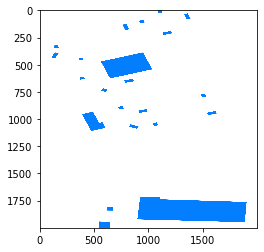

In [9]:
img=mpimg.imread('map.png')
plt.imshow(img)

In [10]:
envelope = m.envelope()
with open("map.yaml", "w") as yamlFile:
  west  = envelope[0]
  south = envelope[1]
  east  = envelope[2]
  north = envelope[3]
  yamlFile.write("map:" + "\n")
  yamlFile.write("  min_lat: " + str(south) + "\n")
  yamlFile.write("  min_lon: " + str(west)  + "\n")
  yamlFile.write("  max_lat: " + str(north) + "\n")
  yamlFile.write("  max_lon: " + str(east)  + "\n")
  print("map:")
  print("  min_lat: " + str(south))
  print("  min_lon: " + str(west))
  print("  max_lat: " + str(north))
  print("  max_lon: " + str(east))


map:
  min_lat: 50.8295206
  min_lon: 6.0236285500000015
  max_lat: 50.8316988
  max_lon: 6.025806749999997
